## A/B Testing for Marketing Use Case

#### Problem Statement

The given Dataset contains data collected from a marketing Ad campaign.
The majority of the people were exposed to ads (the experimental group) and a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.
The marketing team would like to know which of the version of the ads was successful(higher conversions) with the help of statistical analysis.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro,ttest_ind

## Part I - Exploratory Data Analysis

#### Read the dataset

In [2]:
dataset=pd.read_csv(r'C:\Stoa\19. Job Prep\ab test\marketing_AB.csv')

In [3]:
dataset.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


#### The column 'Unnamed: 0' is not useful. Hence, we can drop it.

In [4]:
dataset.drop('Unnamed: 0',axis=1,inplace=True)

#### The dataset contains 588101 rows and 6 columns

In [5]:
dataset.shape

(588101, 6)

#### Replacing the spaces in the columns headers with underscore

In [6]:
dataset.columns=dataset.columns.str.replace(' ','_')
dataset.columns

Index(['user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day',
       'most_ads_hour'],
      dtype='object')

#### Rows containing 'ad' in the test_group are the treatment group and 'psa' are the control group

In [7]:
dataset.test_group.value_counts()

ad     564577
psa     23524
Name: test_group, dtype: int64

#### Checking for nulls and column statistics. The dataset does not contain any null values

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


In [9]:
dataset.describe()

,user_id,total_ads,most_ads_hour
count,5.881010e+05,588101.000000,588101.000000
mean,1.310692e+06,24.820876,14.469061
std,2.022260e+05,43.715181,4.834634
min,9.000000e+05,1.000000,0.000000
25%,1.143190e+06,4.000000,11.000000
50%,1.313725e+06,13.000000,14.000000
75%,1.484088e+06,27.000000,18.000000
max,1.654483e+06,2065.000000,23.000000


#### Checking for duplicate data. All the user_ids are unique

In [10]:
dataset.agg(total_count=('user_id','count'),unique_count=('user_id','nunique'))

,user_id
total_count,588101
unique_count,588101


#### Creating column "group" with treatment and control labels

In [11]:
dataset['group']=dataset.test_group.apply(lambda x:'treatment' if x=='ad' else 'control')

#### Changing Boolean values to 0 or 1

In [12]:
dataset['converted']=dataset['converted'].astype('int')

#### Finding conversion rate for the treatment and control group. Calculating difference between treatment and control group's conversion rates

In [13]:
treatment_rate=dataset[dataset['group']=='treatment']['converted'].mean()

In [14]:
treatment_rate

0.025546559636683747

In [15]:
control_rate=dataset[dataset['group']=='control']['converted'].mean()
control_rate

0.01785410644448223

In [16]:
conv_diff=treatment_rate-control_rate
conv_diff

0.007692453192201517

## Part II - A/B Testing for Conversions

#### Since the metric of choice (conversion rate) is a categorical metric, we can choose two proportion t-test for AB testing

Assumptions for two proportions Z-test:
1. The data are simple random values from both the populations
2. Both populations follow a binomial distribution
3. Samples are independent of each other
4. Test results are accurate when np and n(1-p) are greater than 5


#### Checking for condition np and n(1-p) are greater than 5
**Treatment group**

In [17]:
treatment_rate*dataset[dataset['group']=='treatment'].shape[0]

14423.0

In [18]:
(1-treatment_rate)*dataset[dataset['group']=='treatment'].shape[0]

550154.0

**Control group**

In [19]:
control_rate*dataset[dataset['group']=='control'].shape[0]

420.0

In [20]:
(1-control_rate)*dataset[dataset['group']=='control'].shape[0]

23104.0

#### Visualizing binomial distribution and comparing the distribution of two groups

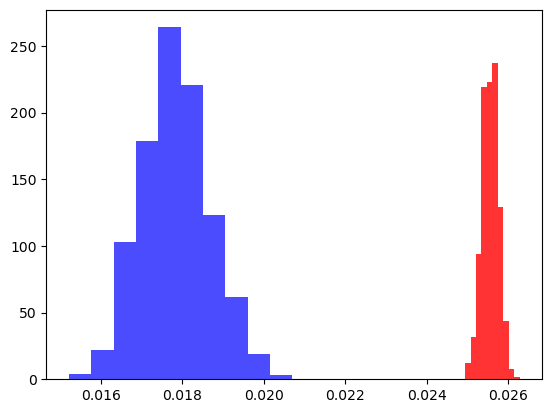

In [21]:
#treatment and control binomial distributions
t_list=[]
c_list=[]
for i in range(1000):
    n_treatment=dataset[dataset['group']=='treatment'].shape[0]
    n_control=dataset[dataset['group']=='control'].shape[0]
    dist_treatment=np.random.binomial(1,treatment_rate,n_treatment)
    dist_control=np.random.binomial(1,control_rate,n_control)
    t_dist_rate=np.mean(dist_treatment)
    c_dist_rate=np.mean(dist_control)
    t_list.append(t_dist_rate)
    c_list.append(c_dist_rate)
    
plt.hist(t_list,label='Treatment',alpha=0.8,color='red')
plt.hist(c_list,label='Control',alpha=0.7,color='blue')
plt.show()

### Two proportion Z-Test

#### Null Hypothesis (H0) : The conversion rate of two groups are equal
#### Alternative Hypothesis (H1) : The conversion rate of the treatment group is higher than the control group
Significance level(alpha) = 0.05
If the P-Value < alpha, we can reject null hypothesis


In [22]:
alpha=0.05
n_treat=dataset[dataset['group']=='treatment'].shape[0]
n_cont=dataset[dataset['group']=='control'].shape[0]
success_count=[treatment_rate*n_treat,control_rate*n_control]
nobs=[n_treat,n_control]

# Since we are trying to test if the treatment rate is greater than the control rate
# we use the treatment parameters first and choose alternative='larger'.
z_stat,p_val = proportions_ztest(success_count,nobs,alternative='larger')

In [37]:
if p_val<alpha:
    print('The p value {} is lesser than the significance level {}.Hence, we can reject the null hypothesis'.format(p_val,alpha))
    print('The conversion rate of the treatment group is higher than that of the control group')
else:
    print('The p value {} is higher than the significance level {}.Hence, we cannot reject the null hypothesis'.format(p_val,alpha))

The p value 8.526403580779863e-14 is lesser than the significance level 0.05.Hence, we can reject the null hypothesis
The conversion rate of the treatment group is higher than that of the control group


## Part III - A/B Testing for total_ads

#### Since the metric of choice (total_ads) is a average user metric, we can choose appropriate test based on the following conditions

If the distribution is normal:
    With equal sample group variance: **Student's t-test**
    Different sample group variance: **Welch t-test**
If the distribution is not normal: **Mann Whitney U test**


#### Null Hypothesis (H0) : Users between both the treatment and control have equal exposure to the ads before conversion
#### Alternative Hypothesis (H1) : Users in the treatment are converted with less exposure to the ads than the control

In [24]:
dataset[(dataset['group']=='treatment') & (dataset['converted']==1)].total_ads.mean()

83.90556749635998

In [25]:
dataset[(dataset['group']=='control') & (dataset['converted']==1)].total_ads.mean()

83.27619047619048

### Checking for normality

#### 1. Plotting the data points
#### 2. Shapiro wilk test for normality

#### The resulting visualization is highly skewed, hence not normal

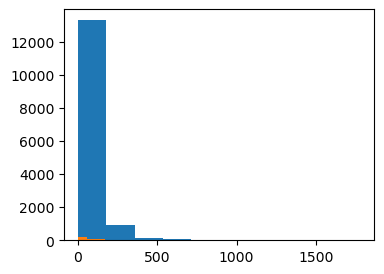

In [26]:
plt.figure(figsize=(4,3))
plt.hist(dataset[(dataset['group']=='treatment') & (dataset['converted']==1)].total_ads)
plt.hist(dataset[(dataset['group']=='control') & (dataset['converted']==1)].total_ads)
plt.show()

#### Shapiro Wilk test for Normality
Null Hypothesis (H0) : The sample distribution is normal
Alternative Hypothesis (H1) : The sample distribution is not normal

#### Normality test for treatment and control group

In [27]:
treatment_df=dataset[(dataset['group']=='treatment') & (dataset['converted']==1)].total_ads
control_df=dataset[(dataset['group']=='control') & (dataset['converted']==1)].total_ads
w_treat,w_treat_pvalue=shapiro(treatment_df)
w_cont,w_cont_pvalue=shapiro(control_df)
print('the treatment p value is',w_treat_pvalue,'. The control p value is',w_cont_pvalue)

the treatment p value is 0.0 . The control p value is 3.031830063669001e-23


C:\Users\Mukunthan\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### The p value is lesser than 0.05 in both the groups. Hence we can reject the null hypothesis stating that the distribution is normal

#### Since the sample distribution is not normal, we can choose Mann Whitney U test. But due to large sample size we cannot use  Mann Whitney U test. However, For large sample size we can assume the normality and perform two sample welch t test.

In [32]:
t_stat,p_value=ttest_ind(treatment_df,control_df)
p_value

0.8844137853312304

In [36]:
if p_value<alpha:
    print('The p value {} is lesser than the significance level {}.Hence, we can reject the null hypothesis'.format(p_value,alpha))
    print('Users in the treatment are converted with less exposure to the ads than the control')
else:
    print('The p value {} is higher than the significance level {}. Hence, we cannot reject the null hypothesis'.format(p_value,alpha))
    print('Users between both the treatment and control have equal exposure to the ads before conversion')

The p value 0.8844137853312304 is higher than the significance level 0.05. Hence, we cannot reject the null hypothesis
Users between both the treatment and control have equal exposure to the ads before conversion
